In [1]:
import time
import datetime
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
 
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
 
from sklearn.manifold import TSNE 

### Helper function for timing

In [2]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
            return None

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  


# Data Pipeline

- Don't normalize the data to have zero mean and unit variance. Min-max scaling (0-1), i.e. dividing by 255 works better for VAE!

- Shuffle, batch and prefetch the data

In [3]:
def preprocess_tfds(dataset, batch_size=32, buffer_size=1024, prefetch_factor=tf.data.experimental.AUTOTUNE, shuffle=True):
    '''
    Create an input pipeline from tf.dataset. 
    Adjusted to only take input as there are no labels for autoencoders.
    Does only do input pipeline optimization when desired (inputs are not None)

    :param dataset: tf.dataset to preprocess
    :param batch_size: int, default batch size is 64
    :param buffer_size: int, default is 1024
    :param prefetch_factor: int, default prefetch size is TF autotune
    :returns: preprocessed tf.dataset
    ''' 
    
    # only use batching if shuffle is set to False
    if not shuffle:
        dataset = dataset.batch(batch_size, drop_remainder=True)
    else:
        dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    
    # casting of the images to float32 and expanding dim since there is no channel dim
    # dividing by 255 to min-max scale the input
    dataset = dataset.map(lambda img, label: (tf.cast(img, tf.float32)/255, tf.cast(label, tf.uint8)), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # prefetch the dataset using AUTOTUNE to automatically find the optimal number of batches to prefetch
    if not prefetch_factor is None:
        dataset = dataset.prefetch(prefetch_factor)
    return dataset

In [4]:
## label codes for later analysis/visualization of encoded dataset
label_code = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# load the entire dataset from tfds (you can also get fashion_mnist from keras)
train_ds, test_ds = tfds.load('fashion_mnist', 
                              split=['train', 'test'], 
                              as_supervised=True, 
                              shuffle_files=False)


train_ds = preprocess_tfds(train_ds)
test_ds = preprocess_tfds(test_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/janosch/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# 2.1. CNN Autoencoder

In [5]:
class CNN_Encoder(tf.keras.layers.Layer):
    def __init__(self, input_dim, latent_dim):
        super(CNN_Encoder, self).__init__()
        
        self.layers = []
        
        # (2,2) strided convolution to downsample
        # padding=same for padding of the input image
        
        self.layers.append(tf.keras.layers.Conv2D(filters=32,
                                                  kernel_size=(3,3),
                                                  strides=(2,2),
                                                  padding='same',
                                                  input_shape=input_dim))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))

        self.layers.append(tf.keras.layers.Conv2D(filters=64,
                                                  kernel_size=(3,3),
                                                  strides=(2,2),
                                                  padding='same'))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))

        # dense layer to set dimension
        self.layers.append(tf.keras.layers.Flatten())
        self.layers.append(tf.keras.layers.Dense(latent_dim, activation='relu'))
        
    def call(self, x, training=False):
        for layer in self.layers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
        return x


class CNN_Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, output_dim, restore_shape):
        super(CNN_Decoder, self).__init__()
        self.layers = []
        
        # dense layer to restore dim of flattend data
        self.layers.append(tf.keras.layers.Dense(units=int(tf.math.reduce_prod((restore_shape))),
                                                 input_shape=(latent_dim,)))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
        
        # reshape to 3 dim with depth dim again
        self.layers.append(tf.keras.layers.Reshape(target_shape=restore_shape))
        
        # (2,2) strided transposed conv to upsample 
        
        self.layers.append(tf.keras.layers.Conv2DTranspose(filters=32,
                                                           kernel_size=(3,3),
                                                           strides=(2,2),
                                                           padding='same'))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
       
        # restore image by convolution with image size
        self.layers.append(tf.keras.layers.Conv2DTranspose(filters=1,
                                                  kernel_size=(3,3),
                                                  strides=(2,2),
                                                  padding='same'))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('sigmoid'))
       
    def call(self, x, training=False):
        for layer in self.layers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
        return x

class CNN_Autoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim, restore_shape=(7,7,64)):
        super(CNN_Autoencoder, self).__init__()
        # encoder and decoder are symmetric
        self.encoder = CNN_Encoder(input_dim=input_dim,
                                   latent_dim=latent_dim)
        self.decoder = CNN_Decoder(latent_dim=latent_dim,
                                   output_dim=input_dim,
                                   restore_shape=restore_shape)
        
    def call(self, x, training=False):
        x = self.encoder(x, training)
        self.latent_repr = x  # keep latent_repr as property in case it should be analyzed
        x = self.decoder(x, training)
        return x
    

## Reconstructed image *before* training the Autoencoder

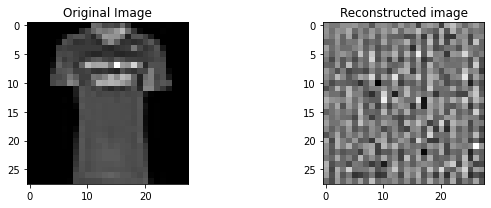

In [6]:
latent_dim = 10
autoencoder = CNN_Autoencoder((None,28,28,1), latent_dim)
first_img = 0

# try autoencoder before training
for img, label in train_ds.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Original Image')
    plt.imshow(img[first_img,:,:,0], cmap='gray')
    
    plt.subplot(122)
    plt.title('Reconstructed image')
    plt.imshow(autoencoder(img)[first_img,:,:,0], cmap='gray')
    plt.tight_layout()
    
    plt.show()

# Defining Train and Evaluation steps
- evaluation step outputs image and reconstructed image for visualization
- epoch is done inside train_step, so iterating over train data is done inside a function with @tf.function decorator.

In [7]:
@tf.function
def train_step_AE(model, train_ds, loss_function, optimizer, train_loss_metric):
    '''
    Training for one epoch. Adjusted for Autoencoder as there are no acc_metric.
    '''
    for img, label in train_ds:  # there are no (input,label) pairs
        with tf.GradientTape() as tape:
            # forward pass
            prediction = model(img, training=True)
            loss = loss_function(img, prediction) 

        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)

@tf.function
def eval_step_AE(model, ds, loss_function, loss_metric):
    '''
    Evaluate without training. Adjusted for autoencoder. 
    Return a random image and reconstructed version of it.
    '''
    prediction = 0.0
    img = 0.0

    for img, label in ds:
        # forward pass
        prediction = model(img, training=False)
        # update metrics
        loss = loss_function(img, prediction)
        loss_metric.update_state(loss)
        
    return img, prediction

## Setting the hyperparameters and instantiating the Autoencoder

- use build method with input shape so you can make use of the summary() method.

- For the summary to work, your layers must call every keras layer that is instantiated (layers that are defined in __init__ must be used in the call method)


In [8]:
# @Hyperparameter
EPOCHS = 25
LEARNING_RATE = 0.001

tf.keras.backend.clear_session()
timer = Timer()

# Define @model
model_AE = CNN_Autoencoder(input_dim=(None,28,28,1), latent_dim=10)
# Define @loss function
loss_function = tf.keras.losses.MeanSquaredError()
# Define @optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# get summary of the model
input_shape = (None,28,28,1) # None for batch size
model_AE.build(input_shape) # needed for summary
model_AE.summary()

Model: "cnn__autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn__encoder (CNN_Encoder)   multiple                  50570     
_________________________________________________________________
cnn__decoder (CNN_Decoder)   multiple                  65925     
Total params: 116,495
Trainable params: 109,965
Non-trainable params: 6,530
_________________________________________________________________


Defining the metrics so we can use them with tensorboard.

In [9]:
train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# Initialize lists for later visualization.
train_losses_AE = []
test_losses_AE = []
times = []

## Train the Autoencoder

- Train and test metric objects are updated with the method **update_state(loss)** inside the train_step and eval_step functions. 
- After one train_step (one epoch) we can get the result of a metric by using the **result()** method. This way we can also store them in an array or a list for visualization with matplotlib or seaborn.
- The metrics must be reset after each epoch using the **reset_states()** method.

## Visualize during training

- Because our eval_step function returns an image batch and the model's reconstruction of it, we can visualize them in each epoch. 
- Note that it's always a different image due to shuffling. It's possible to also set a fixed image that will be reconstructed, so you can better compare between epochs.

[INFO] - Evaluating the Dataset on the cnn__autoencoder before training.
train_loss: 0.1704, test_loss: 0.1697

[EPOCH] ____________________0____________________
[0] - Finished Epoch in 22.31 seconds - train_loss: 0.0364; test_loss: 0.0235

[INFO] - Total time elapsed: 0.5138 min. Total time remaining: 12.3310 min.


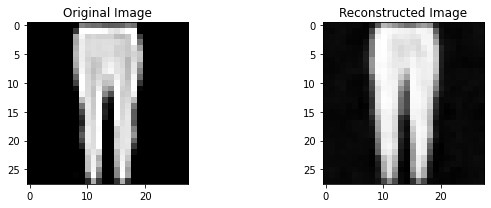


[EPOCH] ____________________1____________________
[1] - Finished Epoch in 21.79 seconds - train_loss: 0.0207; test_loss: 0.0189

[EPOCH] ____________________2____________________


In [ ]:
print(f'[INFO] - Evaluating the Dataset on the {model_AE.name} before training.')
timer.start()

# evaluate once before training 
eval_step_AE(model_AE,
             train_ds,
             loss_function, 
             loss_metric=train_loss_metric)

eval_step_AE(model_AE,  
             test_ds,
             loss_function, 
             loss_metric=test_loss_metric)

# Evaluate the metrics
train_loss = train_loss_metric.result()
train_losses_AE.append(train_loss)
test_loss = test_loss_metric.result()
test_losses_AE.append(test_loss)

train_loss_metric.reset_states()
test_loss_metric.reset_states()

# Evaluate the timer
elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, test_loss: {test_loss:0.4f}')

for epoch in range(EPOCHS):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    timer.start()
    
    # Training step    
    train_step_AE(model_AE, train_ds, loss_function, optimizer, train_loss_metric)
    
    # Test step    
    img_original, img_reconstructed = eval_step_AE(model_AE, test_ds, loss_function, test_loss_metric)
    
    # Evaluate the metrics
    test_loss = test_loss_metric.result()
    test_losses_AE.append(test_loss)
    train_loss = train_loss_metric.result()
    train_losses_AE.append(train_loss)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}; test_loss: {test_loss:0.4f}')
    
    # print progress every while
    if epoch%5 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(EPOCHS-epoch-1)/60:0.4f} min.')
        
        # Visualize reconstructed image      
        plt.figure(figsize=(9, 3))

        plt.subplot(121)
        plt.title('Original Image')
        plt.imshow(img_original[0,:,:,0], cmap='gray')

        plt.subplot(122)
        plt.title('Reconstructed Image')
        plt.imshow(img_reconstructed[0,:,:,0], cmap='gray')

        plt.tight_layout()

        plt.show()
                       
    # Resetting metrics 
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

print(f'\n[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

## Visualize the losses 

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))

x = np.arange(len(train_losses_AE))

# losses
axes.plot(x, train_losses_AE, label='train')
axes.plot(x, test_losses_AE, label='test')
axes.legend()
axes.set(title='Losses', xlabel='Epoch', ylabel='loss')

plt.show()

# **Variational Autoencoder**

The idea of a variational autoencoder is to force the learned representation of the input to be continuous with respect to their semantics. If we want to generate new unseen samples with the ordinary Autoencoder, we most likely would end up with a noise image that isn't meaningful.

Essentially the Variational Autoencoder solves this by forcing the latent representation to be close to a normal distribution.

(is this correct? What else is important to mention?)

In [ ]:
class VEncoder(tf.keras.layers.Layer):
    def __init__(self,latent_dim):
        super(VEncoder,self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=32, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            activation='relu')
        
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=3, 
                                            strides=(2, 2),
                                            activation='relu')
        
        self.flatten =  tf.keras.layers.Flatten()

        self.latent_encoding = tf.keras.layers.Dense(latent_dim + latent_dim)

    def call(self,x,training=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.latent_encoding(x)
        return x

class VDecoder(tf.keras.layers.Layer):
    def __init__(self,latent_dim):
        super(VDecoder,self).__init__()
        
        #self.flatten = tf.keras.layers.Flatten()
        self.dense1= tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu)

        self.reshape = tf.keras.layers.Reshape(target_shape=(7, 7, 32))

        self.conv1 = tf.keras.layers.Conv2DTranspose(filters=64, 
                                                     kernel_size=3, 
                                                     strides=2, 
                                                     padding='same',
                                                     activation='relu')

        self.conv2 = tf.keras.layers.Conv2DTranspose(filters=32, 
                                                     kernel_size=3, 
                                                     strides=2, 
                                                     padding='same',
                                                     activation='relu')

            # No activation
        self.conv3 = tf.keras.layers.Conv2DTranspose(filters=1, 
                                                     kernel_size=3, 
                                                     strides=1, 
                                                     padding='same')
        
    def call(self,x,training=False):
        #x = self.flatten(x)
        x = self.dense1(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [ ]:
class CVAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = VEncoder(latent_dim)
        
        self.decoder = VDecoder(latent_dim)

    @tf.function
    def sample(self, eps=None, training=False):
        '''
        sample a reconstrued image from CVAE.
        :param eps: 2-D array(n, dim(latent_repr)), samples in latent_repr
        :return: N-D array(batch_size, width, height, channel), reconstructed image
        '''
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True, training=False)

    def encode(self, x,training=False):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False,training=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def elbo_loss(model, x, training=False):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
@tf.function
def train_step_VAE(model, train_ds, loss_function, optimizer, train_loss_metric):
    '''
    Training for one epoch. Adjusted for Autoencoder as there are no acc_metric.
    '''
    for img, label in train_ds:  # there are no (input,label) pairs
        with tf.GradientTape() as tape:
            # forward pass
            loss = loss_function(model, img, training=True)
        
        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)

@tf.function
def eval_step_VAE(model, ds, loss_function, loss_metric):
    '''
    Evaluate without training. Adjusted for autoencoder. 
    Return a random image and reconstructed version of it.
    '''
    # evaluate loss
    for img, label in ds:
        loss = loss_function(model, img)
        loss_metric.update_state(loss)
    
    img = 0.0
    prediction = 0.0
   
    # encode image
    for img, label in ds.take(1):
        mean, logvar = model.encode(img)
        z = model.reparameterize(mean, logvar)
        prediction = model.sample(z)
    
    return img, prediction

## Set hyperparameters for the VAE

- latent_dim gives the number of units the encoder produces that represent the mean and (log) variance of the encoded distribution

In [ ]:
# @Hyperparameter
EPOCHS = 25
LEARNING_RATE = 1e-4
latent_dim = 10

tf.keras.backend.clear_session()
timer = Timer()

# Define @model
input_shape = (None,28,28,1)
model_VAE = CVAE(input_dim=input_shape, 
                 latent_dim= latent_dim)

# Define @optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)


In [ ]:
train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# Initialize lists for later visualization.
train_losses_VAE = []
test_losses_VAE = []
times = []

In [ ]:
print(f'[INFO] - Evaluating the Dataset on the {model_VAE.name} before training.')
timer.start()

# evaluate once before training 
eval_step_VAE(model_VAE,
              train_ds, 
              elbo_loss,
              loss_metric=train_loss_metric)

eval_step_VAE(model_VAE,  
              test_ds,
              elbo_loss,
              loss_metric=test_loss_metric)

# update metrics
train_loss = train_loss_metric.result()
train_losses_VAE.append(train_loss)
test_loss = test_loss_metric.result()
test_losses_VAE.append(test_loss)
train_loss_metric.reset_states()
test_loss_metric.reset_states()

# update timer
elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, test_loss: {test_loss:0.4f}')

for epoch in range(EPOCHS):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    timer.start()
    
    # Training step    
    train_step_VAE(model_VAE, train_ds, elbo_loss, optimizer, train_loss_metric)
    
    # Test step    
    img_original, img_reconstructed = eval_step_VAE(model_VAE, test_ds, elbo_loss, test_loss_metric)
    
    # Evaluate the metrics
    test_loss = test_loss_metric.result()
    test_losses_VAE.append(test_loss)
    train_loss = train_loss_metric.result()
    train_losses_VAE.append(train_loss)
    
    # update timer
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}; test_loss: {test_loss:0.4f}')
    
    # print progress every while
    if epoch%5 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(EPOCHS-epoch-1)/60:0.4f} min.')
        
        # Visualize reconstructed image
        plt.figure(figsize=(9, 3))

        plt.subplot(121)
        plt.title('Original Image')
        plt.imshow(img_original[0,:,:,0], cmap='gray')

        plt.subplot(122)
        plt.title('Reconstructed Image')
        plt.imshow(img_reconstructed[0,:,:,0], cmap='gray')

        plt.tight_layout()

        plt.show()

    # Resetting metrics 
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

print(f'\n[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))

x = np.arange(len(train_losses_VAE))

# losses
axes.plot(x, train_losses_VAE, label='train')
axes.plot(x, test_losses_VAE, label='test')
axes.legend()
axes.set(title='Losses', xlabel='Epoch', ylabel='loss')

plt.show()

## Combining images

- take the mean of two encodings of images.

- if we want 80% of one image and 20% of another, we take the weighted mean instead.

- Here we use keras to load the Dataset instead of tfds.

- We reimport the dataset for the visualization so we can have larger batches and no shuffling.

In [ ]:
(_, _), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()

test_x = tf.data.Dataset.from_tensor_slices(test_x)
test_x = test_x.map(lambda img: tf.expand_dims(img, axis=-1))  # no channel dimension

test_y = tf.data.Dataset.from_tensor_slices(test_y)
test_ds_eval = tf.data.Dataset.zip((test_x, test_y))

# preprocess without batches
test_xy = preprocess_tfds(test_ds_eval, 
                          batch_size=1000, 
                          buffer_size=1000, 
                          prefetch_factor=None,
                          shuffle=False)

test_xy= test_xy.take(1000) # take 10000 images for t-sne analysis instead of 1000. This gives better visibility of clusters.

Getting the embeddings for VAE and AE
- converting label integers to string

- for VAE we want two embeddings. One is reparameterized (for sampling images/decoding). The other (for t-sne) is just the mean of the encoded distribution. Reparameterization adds noise which leads to no clusters being visible in the t-sne plot for VAE.

In [ ]:

latent_representation_AE = []
labels_AE = []

latent_representation_VAE = []
latent_representation_VAE_TSNE = []

labels_VAE = []


for n, (img, label) in enumerate(test_xy):
    if n == 0:
        img0 = img
    # for AE
    latent_representation_AE.append(model_AE.encoder(img).numpy())
    labels_AE.append(label)

    # for VAE
    mean,logvar = model_VAE.encode(img)
    latent_representation_VAE.append(   
                                       model_VAE.reparameterize(mean,logvar).numpy()
                                                                                              )
    latent_representation_VAE_TSNE.append( mean.numpy()   ) # for t-sne we look at the mean (since the reparameterization adds noise, which leads to clusters being invisible)

    labels_VAE.append(label)



# create an array with all representations and another array with the corresponding labels (as strings)

latent_ds_AE = np.array(latent_representation_AE).reshape((-1, latent_dim))
latent_labels_AE = np.array(labels_AE)
latent_labels_AE = np.array(latent_labels_AE).reshape((-1))
latent_labels_string_AE = [label_code[i] for i in latent_labels_AE]

latent_ds_VAE = np.array(latent_representation_VAE).reshape((-1, 10))
latent_ds_VAE_TSNE = np.array(latent_representation_VAE_TSNE).reshape((-1, 10))
latent_labels_VAE = np.array(labels_VAE)
latent_labels_VAE = np.array(latent_labels_VAE).reshape((-1))
latent_labels_string_VAE = [label_code[i] for i in latent_labels_VAE]

## Interpolating between images
Below we visualize an interpolation between two images. We also added an extra aspect (that was not required in the homework): noise. By adding noise to the combined latent representations and comparing the results, we want to show a property of VAE in contrast to AE.

In [ ]:
# select which two images should be interpolated and the weighting.
ind0  = 1
ind1  = 100
rate = 0.5
noise_level = 2

In [ ]:
interpol_repr_AE = (rate* latent_ds_AE[ind0] + (1-rate) * latent_ds_AE[ind1])
interpol_repr_VAE = (rate* latent_ds_VAE[ind0] + (1-rate) * latent_ds_VAE[ind1])

rec_img = model_AE.decoder(tf.expand_dims(interpol_repr_AE,axis=0))
rec_img_VAE = model_VAE.sample(tf.expand_dims(interpol_repr_VAE,axis=0))

# interpolated representations with noise added
assert interpol_repr_AE.shape == interpol_repr_VAE.shape

# normal distribution with zero mean for each dimension

noise = np.random.multivariate_normal(mean = np.zeros(interpol_repr_AE.shape[0]),
                                      cov = noise_level * np.eye(interpol_repr_AE.shape[0])).astype('float32')

rec_img_noise = model_AE.decoder(tf.expand_dims(interpol_repr_AE + noise,axis=0))
rec_img_VAE_noise = model_VAE.sample(tf.expand_dims(interpol_repr_VAE + noise,axis=0))



fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(15,10))
ax[0,0].imshow(img0[ind0,:,:,0], cmap='gray')
ax[0,0].set_title(latent_labels_string_VAE[ind0])
ax[1,0].imshow(img0[ind1,:,:,0], cmap='gray')
ax[1,0].set_title(latent_labels_string_VAE[ind1])

ax[0,1].imshow(rec_img[0,:,:,0], cmap='gray')
ax[0,1].set_title("Autoencoder interpolation")
ax[1,1].imshow(rec_img_VAE[0,:,:,0],cmap='gray')
ax[1,1].set_title("Variational Autoencoder interpolation")

ax[0,2].imshow(rec_img_noise[0,:,:,0],cmap="gray")
ax[0,2].set_title("Autoencoder interpolation + noise")
ax[1,2].imshow(rec_img_VAE_noise[0,:,:,0],cmap="gray")
ax[1,2].set_title("Variational Autoencoder interpolation + noise")


print('VAE: interpolated image of {} and {} at the right'.format(latent_labels_string_VAE[ind0],
                                               latent_labels_string_VAE[ind1]))

## Interpretation

We can see that while the standard Autoencoder appears to be unaffected by the noise, the VAE reacts quite strongly to it.

This can be seen as a feature rather than a bug. It means the VAE can generate new samples by slightly changing the representation. The learned latent representation space is in some sense continuous with it's semantics.

# t-SNE analysis of the learned encodings for both AE and VAE

- We want to visualize the learned representations and how easily it is to differentiate between classes given these representations. 

- For this we want to represent encoded image vectors as a point in space (2D for visualization).

- Since the learned representations of an image are of a dimensionality higher than 2 (here we chose 10), we can not simply represent each encoded image as a point on a cartesian coordinate system. 

- For this we reduce the dimensionality with t-sne. t-sne tries to keep distances between points. (so the distance between two encodings in higher dimensional space should roughly be the same as in the 2D projection)

In [ ]:
## fit and apply t-sne on the representations (from sci-kit learn)
tsne_AE = TSNE(n_components=2, random_state=0)
tsne_obj_AE= tsne_AE.fit_transform(latent_ds_AE)

tsne_VAE = TSNE(n_components=2, random_state=0)
tsne_obj_VAE= tsne_VAE.fit_transform(latent_ds_VAE_TSNE)

In [ ]:
# plot for AE with seaborn
plt.figure(figsize=(10, 7.5))
tsne_plot_AE = sns.scatterplot(x=tsne_obj_AE[:,0], 
                            y=tsne_obj_AE[:,1],
                            hue=latent_labels_string_AE,
                            palette=['purple','red','orange','brown','blue',
                                    'dodgerblue','green','lightgreen','darkcyan', 'black'],
                            legend='full')

tsne_plot_AE.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
tsne_plot_AE.set_title('[Autoencoder] - t-SNE of the learned encodings', fontdict={'fontsize': 25})

plt.show()

#plot for VAE
plt.figure(figsize=(10, 7.5))

tsne_plot_VAE = sns.scatterplot(x=tsne_obj_VAE[:,0], 
                            y=tsne_obj_VAE[:,1],
                            hue=latent_labels_string_VAE,
                            palette=['purple','red','orange','brown','blue',
                                    'dodgerblue','green','lightgreen','darkcyan', 'black'],
                            legend='full')

tsne_plot_VAE.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
tsne_plot_VAE.set_title('[Variational Autoencoder] - t-SNE of the learned encodings', fontdict={'fontsize': 25})

plt.show()


## Interpretation

We see that both the autoencoder and the variational Autoencoder have space in between their representations. One reason for this is that we have not displayed all data-points (all possible shoes, jackets etc. that exist). If it were, we would expect the VAE plot to be more densely packed compared to the AE plot. This is because VAE learns continuous latent distributions as the encoding. 

Above we have seen that adding noise to the latent encoding modified the result more strongly for the VAE compared to the AE. This showed that VAE can naturally encode any piece of cloth (e.g. a sandal-cloak mixup) with a normal distribution. So the output is in some sense expected to be continuous with respect to the latent representation while this is not the case for the normal Autoencoder.